In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['Microsoft Yahei']  # Fix Chinese unrecognized issue 
plt.rcParams['axes.unicode_minus']=False # Fix Minus Sign unrecognized issue

# 特定时段全部订单数据

In [2]:
# 数据来自Amazon后台: “Reports/Fulfillment/All Orders”导出txt文件，转xlsx文件。（“product-name/asin”列已删除）
order_df = pd.read_excel('amz_all_orders_201907.xlsx', usecols=['sku', 'quantity'])
# 添加款式字段
order_df['model'] = pd.Series(order_df['sku'].str.replace('CA-', '')).str.slice(0,6)
order_df.head()

,sku,quantity,model
0,HM0807-3542,1,HM0807
1,CA-HM0731-2241,1,HM0731
2,HM0702-841,1,HM0702
3,HM0741-1641,1,HM0741
4,HM0702-1041,1,HM0702


# 该时段FBM退货数据

In [3]:
# 数据来自Amazon后台: “Reports/Return Reports/Seller Fulfilled Return Reports”导出tsv文件，转csv文件。（“asin/item-name”列已删除）
fbm_df = pd.read_csv('amz_reutrns_fbm_201907.csv', usecols=['Merchant SKU', 'Return quantity', 'Return reason'])
# 添加款式字段
fbm_df['model'] = pd.Series(fbm_df['Merchant SKU'].str.replace('CA-', '')).str.slice(0,6)
fbm_df.head()

,Merchant SKU,Return quantity,Return reason,model
0,HM0728-1039,1,CR-MISSED_ESTIMATED_DELIVERY,HM0728
1,HM0738-141,1,AMZ-PG-APP-TOO-SMALL,HM0738
2,HM0725-2739,1,CR-MISSED_ESTIMATED_DELIVERY,HM0725
3,HM0744-239,1,CR-DEFECTIVE,HM0744
4,HM0725-2739,1,CR-ORDERED_WRONG_ITEM,HM0725


# 该时段FBA退货数据

In [4]:
# 数据来自Amazon后台: “Reports/Fulfillment/FBA Customer Returns”导出csv文件。（“asin/fnsku/product-name”列已删除）
fba_df = pd.read_csv('amz_reutrns_fba_201907.csv', usecols=['sku', 'quantity', 'reason', 'customer-comments'])
# 添加款式字段
fba_df['model'] = pd.Series(fba_df['sku'].str.replace('CA-', '')).str.slice(0,6)
fba_df.head()

,sku,quantity,reason,customer-comments,model
0,HM0731-Z-40,1,APPAREL_STYLE,NaN,HM0731
1,HM0759-1039,1,APPAREL_TOO_LARGE,NaN,HM0759
2,HM0738-139,1,APPAREL_TOO_SMALL,NaN,HM0738
3,HM0731-H-35,1,APPAREL_TOO_SMALL,NaN,HM0731
4,HM0701-H-41,1,APPAREL_TOO_SMALL,NaN,HM0701


In [5]:
# 以下语句将所有不重复的FBA顾客退货留言输出保存到CSV文件。
# fba_df['customer-comments'].dropna().drop_duplicates().to_csv('amz_returns_customer_comments_201907.csv', header=['customer-comments'])

# 退货款式情况统计

In [6]:
returns_df = fba_df.groupby('model').sum().merge(fbm_df.groupby('model').sum(), how='outer', left_on='model', right_on='model', sort=True).fillna(0)
returns_df['count'] = returns_df['quantity'] + returns_df['Return quantity']

# 全部订单销量款式情况统计

In [7]:
sales_df = (order_df.groupby('model').sum())
sales_df = sales_df[sales_df.quantity > 0]

# 二表合一

In [8]:
result_df = sales_df.merge(returns_df, how='left', left_on='model', right_on='model', sort=True).fillna(0)
result_df.reset_index(inplace=True)
result_df.columns = ['款式', '销售数量', 'FBA退货数量', 'FBM退货数量', '退货总数']
result_df['退货比例'] = round(result_df['退货总数'] / result_df['销售数量'] * 100, 2)
result_df

,款式,销售数量,FBA退货数量,FBM退货数量,退货总数,退货比例
0,HM0505,17,3.0,0.0,3.0,17.65
1,HM0701,695,63.0,3.0,66.0,9.50
2,HM0702,4,0.0,0.0,0.0,0.00
3,HM0706,60,4.0,0.0,4.0,6.67
4,HM0707,5,0.0,0.0,0.0,0.00
5,HM0708,3,0.0,0.0,0.0,0.00
6,HM0709,16,4.0,2.0,6.0,37.50
7,HM0711,13,0.0,0.0,0.0,0.00
8,HM0712,1,0.0,0.0,0.0,0.00
9,HM0713,14,0.0,0.0,0.0,0.00


# 商品款式退货率排序图表

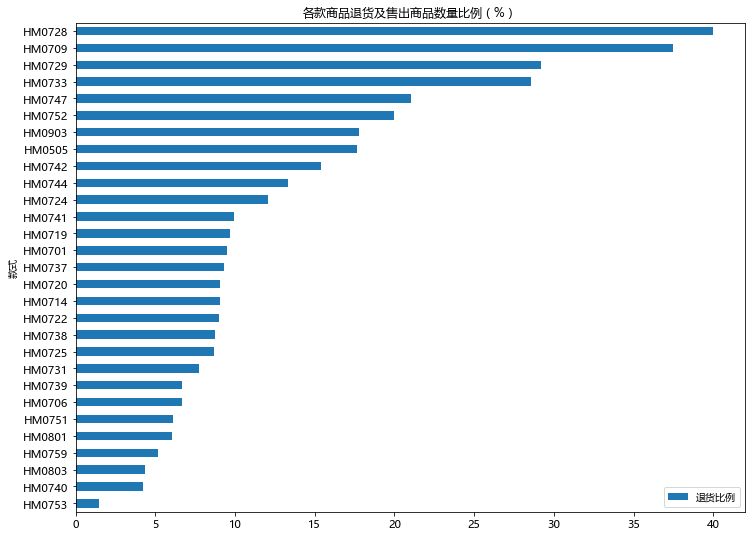

In [9]:
bar_df = result_df[result_df.退货比例>0].sort_values(by='退货比例', ascending=True)
bar_df.plot(
    kind='barh', 
    x = 0,
    y = '退货比例',
    grid = False,
    table = False,
    title='各款商品退货及售出商品数量比例（%）', 
    figsize=(12, 9),
    fontsize=11
)

[返回目录](amz_returns_catalog.ipynb)